# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself.

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [5]:
%matplotlib inline
import math, numpy as np, matplotlib.pyplot as plt
import operator

## Create data

In [6]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [17]:
centroids = np.random.uniform(-35., 35., (n_clusters, 2)) # dimension = 2, because each point is (x, y)
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples) 
          for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [30]:
def plot_data(centroids, data, n_samples):
    colour = plt.cm.rainbow(np.linspace(0, 1, len(centroids)))
    for i, centroid in enumerate(centroids):
        samples = data[n_samples*i: n_samples*(i+1)]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i], s=1)
        plt.plot(centroid[0], centroid[1], marker='x', markersize=10, color='k', mew=5)
        plt.plot(centroid[0], centroid[1], marker='x', markersize=5, color='r', mew=2)

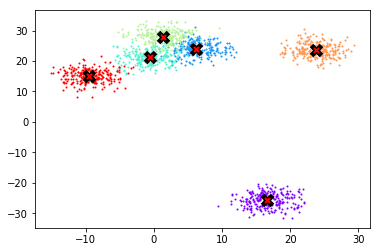

In [31]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
![Gaussian](http://images.books24x7.com/bookimages/id_5642/fig11-10.jpg)
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

So here's the definition of the gaussian kernel, which you may remember from high school...

In [33]:
def gaussion(d, bw): # bw: bandwidth = std (sigma)
    return 1/math.sqrt(2 * bw**2 * math.pi) * np.exp(- 1/2 * (d/bw)**2)

 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [94]:
# IMPORTANT numpy Broadcast tutorial

dat = data[:5]
print(dat.shape)
weight = np.ndarray([5])
print(weight.shape)

# Solution 1: This works after expanding dimension
weight_sol1 = np.expand_dims(weight, 1)
test_sol1 = weight_sol1 * dat
print(test_sol1.shape)

# Solution 2: This works after reshaping by (-1, 1)
weight_sol2 = weight.reshape(-1, 1)
test_sol2 = weight_sol2 * dat
print(test_sol2.shape)

# This fails when ndarray is in shape like (1500,)
test = weight * dat
print(test.shape)

(5, 2)
(5,)
(5, 2)
(5, 2)


ValueError: operands could not be broadcast together with shapes (5,) (5,2) 

In [97]:
d = np.copy(data)
p = gaussion(np.sqrt(((d[0]-d)**2).sum(1)), 2.5)
print(p.shape)
print(p.reshape(-1, 1).shape)
print(np.expand_dims(p, 1).shape)

t = (np.expand_dims(p,1) * d).sum(0) / weight.sum()
print(t.shape)

print(d[0].shape)

(1500,)
(1500, 1)
(1500, 1)
(2,)
(2,)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [98]:
def mean_shift(data):
    X = np.copy(data)
    for it in range(5):
        for i, x in enumerate(X):
            dist = np.sqrt(((x-X)**2).sum(1))
            weight = gaussion(dist, 2.5)
            X[i] = (np.expand_dims(weight,1) * X).sum(0) / weight.sum()
    return X

In [99]:
%time X = mean_shift(data)

Wall time: 1.79 s


We can see that mean shift clustering has almost reproduced our original clustering. The one exception are the very close clusters, but if we really wanted to differentiate them we could lower the bandwidth.

What is impressive is that this algorithm nearly reproduced the original clusters without telling it how many clusters there should be.

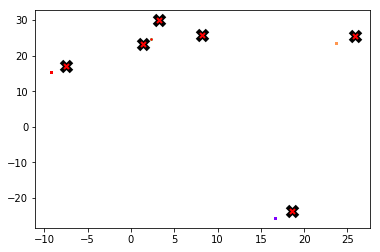

In [112]:
plot_data(centroids+2, X, n_samples)

We should be able to accelerate this algorithm with a GPU.

In [ ]:
def mean_shift(data):
    X = np.copy(data)
    for it in range(5):
        x = np.expand_dims(data, 0)
        x[1] = x[0] 
        for i, x in enumerate(X):
            dist = np.sqrt(((x-X)**2).sum(1))
            weight = gaussion(dist, 2.5)
            X[i] = (np.expand_dims(weight,1) * X).sum(0) / weight.sum()
    return X